This notebook compares the numbers that go in and out of components of this architecture.

In [3]:
from src.models.latent_models import LatentVQVAE
import yaml

# Configuration for the model
model_config_path = "../models/latent_vqvae/configs/sd35m_to_512d.yaml"

# Load model config
with open(model_config_path, "r") as f:
    model_config = yaml.safe_load(f)

ckpt_path = "../models/latent_vqvae/version_5/checkpoints/last.ckpt"

# Initialize model
latent_vqvae = LatentVQVAE(
    ddconfig=model_config["ddconfig"],
    lossconfig=model_config["lossconfig"],
    n_embed=model_config["embedconfig"]["n_embed"],
    embed_dim=model_config["embedconfig"]["embed_dim"],
    ckpt_path=ckpt_path,
    monitor="val_total_loss",
)

latent_vqvae.eval()
latent_vqvae

making attention of type 'none' with 128 in_channels
Working with z of shape (1, 8, 8, 8) = 512 dimensions.
making attention of type 'none' with 128 in_channels
Restored from ../models/latent_vqvae/version_5/checkpoints/last.ckpt with 0 missing and 223 unexpected keys
Unexpected Keys: ['model_ema.decay', 'model_ema.num_updates', 'model_ema.encoderconv_inweight', 'model_ema.encoderconv_inbias', 'model_ema.encoderdown0block0norm1weight', 'model_ema.encoderdown0block0norm1bias', 'model_ema.encoderdown0block0conv1weight', 'model_ema.encoderdown0block0conv1bias', 'model_ema.encoderdown0block0norm2weight', 'model_ema.encoderdown0block0norm2bias', 'model_ema.encoderdown0block0conv2weight', 'model_ema.encoderdown0block0conv2bias', 'model_ema.encoderdown0block1norm1weight', 'model_ema.encoderdown0block1norm1bias', 'model_ema.encoderdown0block1conv1weight', 'model_ema.encoderdown0block1conv1bias', 'model_ema.encoderdown0block1norm2weight', 'model_ema.encoderdown0block1norm2bias', 'model_ema.enco

LatentVQVAE(
  (encoder): Encoder(
    (conv_in): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 64, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (1): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 64, eps=1e-06, affine=True)
            (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupN

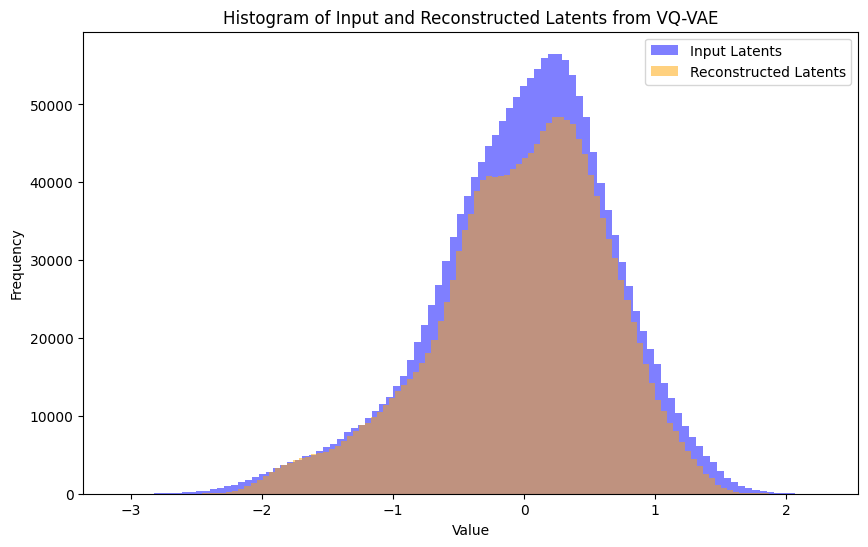

In [4]:
# Histogram that compares the input latents and the reconstructed latents
import os
import glob
import random
import torch

# Load the latents from the folder
SD_LATENT_PATHS = glob.glob(os.path.join("../data/ffhq/sd_latents/", "*.pt"))

# Select 100 random latents
random.seed(42)
random.shuffle(SD_LATENT_PATHS)
selected_paths = SD_LATENT_PATHS[:100]

inputs = []
reconstructions = []
# Loop through the selected latents
for path in selected_paths:
    # Load the latent
    sd_latent = torch.load(path, weights_only=False)
    # Encode the latent using the LatentVQVAE
    latent = latent_vqvae.encode(sd_latent.unsqueeze(0))[0]
    # Decode the latent using the LatentVQVAE
    recon = latent_vqvae.decode(latent).squeeze(0).detach()
    # Store input and reconstructed latents
    inputs.append(sd_latent)
    reconstructions.append(recon)

# Plot histograms for the input and reconstructed latents in one plot
import matplotlib.pyplot as plt

# Flatten the tensors for histogram plotting
input_flat = torch.cat([x.flatten() for x in inputs])
recon_flat = torch.cat([x.flatten() for x in reconstructions])

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(input_flat.cpu().numpy(), bins=100, alpha=0.5, label='Input Latents', color='blue')
plt.hist(recon_flat.cpu().numpy(), bins=100, alpha=0.5, label='Reconstructed Latents', color='orange')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Input and Reconstructed Latents from VQ-VAE')
plt.legend()
plt.show()

In [ ]:
# Histogram that compares original latents and BO latents
import os
import glob
import random
import torch

# Load the latents from the folder
SD_LATENT_PATHS = glob.glob(os.path.join("../data/ffhq/sd_latents/", "*.pt"))

# Select 100 random latents
random.seed(42)
random.shuffle(SD_LATENT_PATHS)
selected_paths = SD_LATENT_PATHS[:100]

input_latents = []
# Loop through the selected latents
for path in selected_paths:
    # Load the latent
    sd_latent = torch.load(path, weights_only=False)
    # Encode the latent using the LatentVQVAE
    latent = latent_vqvae.encode(sd_latent.unsqueeze(0))[0].squeeze().detach()
    # Store the latent
    input_latents.append(latent)

bo_latents = []
# Loop through the selected latents
for iter in range(0, 100, 5):
    for img in range(5):
        # Load the latent
        latent = torch.load(f"../results/debug_07/data/samples/iter_{iter}/latents/tensor_{img}.pt", weights_only=False)
        # Store the latent
        bo_latents.append(latent)

# Plot histograms for the input and reconstructed latents in one plot
import matplotlib.pyplot as plt

# Flatten the tensors for histogram plotting
input_flat = torch.cat([x.flatten() for x in input_latents])
bo_flat = torch.cat([x.flatten() for x in bo_latents])

print(input_flat.mean(), input_flat.std())

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(input_flat.cpu().numpy(), bins=100, alpha=0.5, label='Input Latents', color='blue')
plt.hist(bo_flat.cpu().numpy(), bins=100, alpha=0.5, label='BO Latents', color='orange')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Input and Output Latents from BO')
plt.legend()
plt.show()

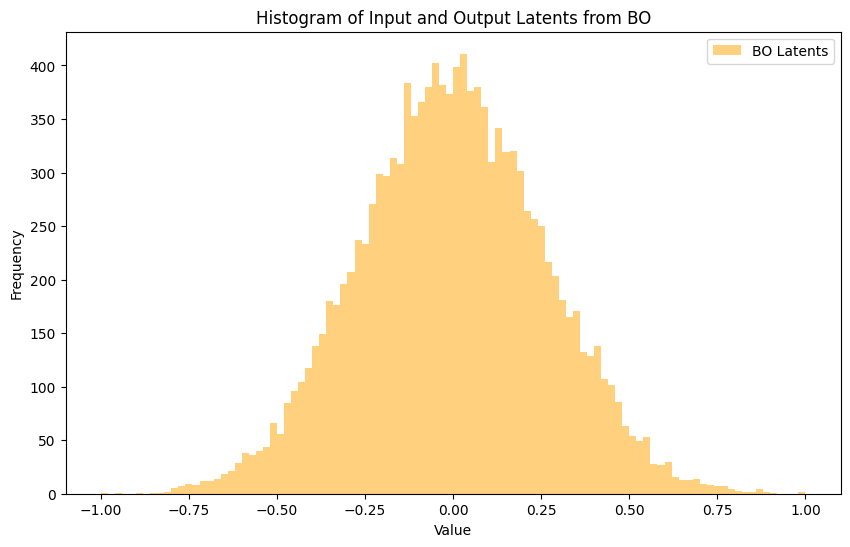

In [22]:
import torch

bo_latents = []
# Loop through the selected latents
for iter in range(0, 25, 5):
    for img in range(5):
        # Load the latent
        latent = torch.load(f"../results/debug_07/data/samples/iter_{iter}/latents/tensor_{img}.pt", weights_only=False)
        # Store the latent
        bo_latents.append(latent)

# Plot histograms for the input and reconstructed latents in one plot
import matplotlib.pyplot as plt

# Flatten the tensors for histogram plotting
bo_flat = torch.cat([x.flatten() for x in bo_latents])

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(bo_flat.cpu().numpy(), bins=100, alpha=0.5, label='BO Latents', color='orange')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Input and Output Latents from BO')
plt.legend()
plt.show()

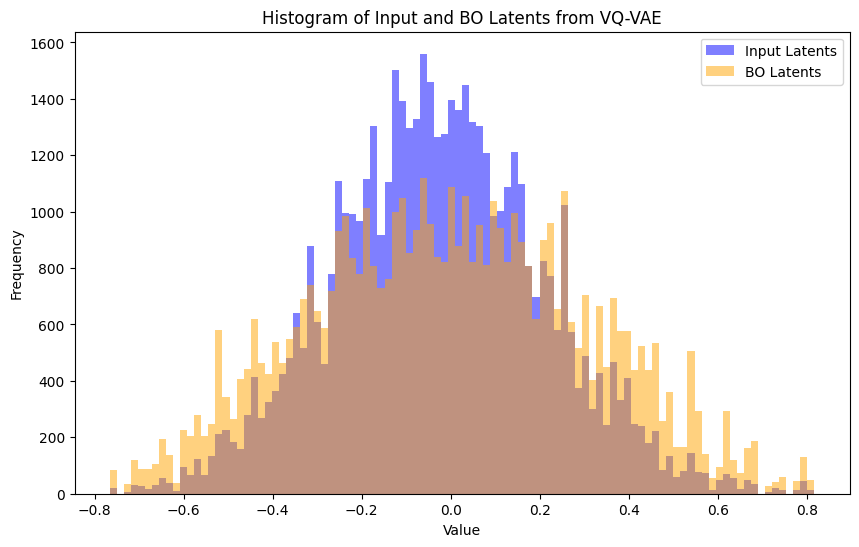

In [21]:
# Histogram that compares original latents and BO latents
# Here we are not directly taking the latents, but re-encoding the SD latents
import os
import glob
import random
import torch

# Load the latents from the folder
SD_LATENT_PATHS = glob.glob(os.path.join("../data/ffhq/sd_latents/", "*.pt"))

# Select 100 random latents
random.seed(42)
random.shuffle(SD_LATENT_PATHS)
selected_paths = SD_LATENT_PATHS[:100]

input_latents = []
# Loop through the selected latents
for path in selected_paths:
    # Load the latent
    sd_latent = torch.load(path, weights_only=False)
    # Encode the latent using the LatentVQVAE
    latent = latent_vqvae.encode(sd_latent.unsqueeze(0))[0].squeeze().detach()
    # Store the latent
    input_latents.append(latent)

bo_latents = []
# Loop through the selected latents
for iter in range(0, 100, 5):
    for img in range(5):
        # Load the latent
        sd_latent = torch.load(f"../results/lso_dngo_03/data/sampled_data_iter{iter}/sd_latents/tensor_{img}.pt", weights_only=False)
        # Encode the latent using the LatentVQVAE
        latent = latent_vqvae.encode(sd_latent.unsqueeze(0))[0].squeeze().detach()
        # Store the latent
        bo_latents.append(latent)

# Plot histograms for the input and reconstructed latents in one plot
import matplotlib.pyplot as plt

# Flatten the tensors for histogram plotting
input_flat = torch.cat([x.flatten() for x in input_latents])
bo_flat = torch.cat([x.flatten() for x in bo_latents])

# Plot histograms
plt.figure(figsize=(10, 6))
plt.hist(input_flat.cpu().numpy(), bins=100, alpha=0.5, label='Input Latents', color='blue')
plt.hist(bo_flat.cpu().numpy(), bins=100, alpha=0.5, label='BO Latents', color='orange')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Input and BO Latents from VQ-VAE')
plt.legend()
plt.show()

Min: -1.3523324312902345, Max: 1.5808597273801612, Mean: 0.0005288246184657195, Std: 0.30017219587473587


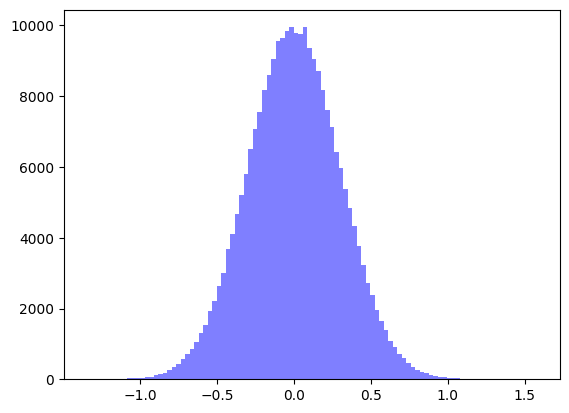

In [16]:
import numpy as np

latent_grid = np.random.normal(loc=0.0, scale=0.3, size=(500, 512))

print(f"Min: {latent_grid.min()}, Max: {latent_grid.max()}, Mean: {latent_grid.mean()}, Std: {latent_grid.std()}")

import matplotlib.pyplot as plt

plt.hist(latent_grid.flatten(), bins=100, alpha=0.5, label='Latent Grid', color='blue')
plt.show()